In [1]:
%matplotlib notebook

import os
from PIL import Image
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.6f}'.format)

pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.max_colwidth', None)  # Display full content of each field

In [2]:
def build_image_list(input_dir):
    # Create an empty list to store the data
    data = []

    # Define the subdirectories to look for
    subdirs = ["DSO", "Lunar", "Planets", "Comets"]

    # Walk through each subdirectory
    for subdir in subdirs:
        subdir_path = os.path.join(input_dir, subdir)
        if not os.path.exists(subdir_path):
            continue
        # Walk through the directory tree
        for root, _, files in os.walk(subdir_path):
            for file in files:
                if file.endswith('.png'):
                    # Determine the "name"
                    if subdir == "Lunar":
                        name = "Moon"
                    else:
                        relative_path = os.path.relpath(root, subdir_path)
                        name = relative_path.split(os.sep)[0] if os.sep in relative_path else relative_path                        
                    
                    # Check for the presence of a "duplicate.dat" file in the same directory
                    duplicate_file_path = os.path.join(root, "duplicate.dat")
                    duplicate = os.path.exists(duplicate_file_path)

                    # Add a row for each PNG file
                    data.append({
                        "source": os.path.join(root, file),
                        "objectClass": subdir,
                        "objectId": name.lower(),
                        "duplicate": duplicate
                    })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data, columns=["source", "objectClass", "objectId", "duplicate"])
    return df

def add_image_metadata (df_images, df_dso):
    columns_to_merge = ['displayName', 'type']
    df_images = df_images.merge(df_dso[['objectId'] + columns_to_merge], on='objectId', how='left')

    # Add planets, moon, and comet metadata
    df_images.loc[df_images['objectId'] == 'moon', 'displayName'] = 'Moon'
    df_images.loc[df_images['objectId'] == 'venus', 'displayName'] = 'Venus'
    df_images.loc[df_images['objectId'] == 'mars', 'displayName'] = 'Mars'
    df_images.loc[df_images['objectId'] == 'jupiter', 'displayName'] = 'Jupiter'
    df_images.loc[df_images['objectId'] == 'saturn', 'displayName'] = 'Saturn'
    df_images.loc[df_images['objectId'] == 'p12', 'displayName'] = 'Comet 12P/Pons-Brooks'
    df_images.loc[df_images['objectId'] == 'a3', 'displayName'] = 'C/2023 A3 (Tsuchinshan-ATLAS)'

    df_images.loc[df_images['objectClass'] == 'Planets', 'type'] = 'planet'
    df_images.loc[df_images['objectClass'] == 'Lunar', 'type'] = 'moon'
    df_images.loc[df_images['objectClass'] == 'Comets', 'type'] = 'comet'
    
    return df_images

def process_for_website(df_images, destination_dir):
    df_web = df_images.copy()
    df_web['thumbnail'] = False
    df_web['cropnail_dim'] = 0
    
    df_web.loc[df_web['objectId'] == 'm1', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'ngc1977', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'm42', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'ngc7293', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'ic434', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'm13', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'm33', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'a3', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'p12', 'thumbnail'] = True
    df_web.loc[df_web['objectId'] == 'mars', 'cropnail_dim'] = 200
    df_web.loc[df_web['objectId'] == 'venus', 'cropnail_dim'] = 300
    df_web.loc[df_web['objectId'] == 'jupiter', 'cropnail_dim'] = 600
    df_web.loc[df_web['objectId'] == 'saturn', 'cropnail_dim'] = 300

    
    for _, row in df_web.iterrows():
        source_file = row['source']
        object_id = row['objectId']
        image_type = row['type']
        duplicate = row['duplicate']
        thumbnail_flag = row['thumbnail']
        cropnail_dim = row['cropnail_dim']

        # Create the type subdirectory in the destination directory
        type_subdir = os.path.join(destination_dir, image_type)
        os.makedirs(type_subdir, exist_ok=True)
        
        thumbs_subdir = os.path.join(type_subdir, "thumbs")
        os.makedirs(thumbs_subdir, exist_ok=True)

        # Generate the destination filename
        destination_filename = ensure_unique_filename(type_subdir, f"{object_id}.jpeg")
        destination_path = os.path.join(type_subdir, destination_filename)

        # Convert the source file to JPEG and save it
        try:
            with Image.open(source_file) as img:
                img.convert("RGB").save(destination_path, "JPEG", quality=100)
            #print(f"Processed {source_file} -> {destination_path}")
        except Exception as e:
            print(f"Error processing {source_file}: {e}")
            
        if thumbnail_flag and duplicate==False:
            thumb_path = os.path.join(thumbs_subdir, f"{object_id}.jpeg")
            aspect_ratio = img.width / img.height
            thumb_width = int(540 * aspect_ratio)
            img.thumbnail((thumb_width, 540))
            img.convert("RGB").save(thumb_path, "JPEG", quality=100)
            
        if (cropnail_dim != 0) and duplicate==False:
            cropnail_path = os.path.join(thumbs_subdir, f"{object_id}_thumbnail.jpeg")
            try:
                with Image.open(source_file) as img:
                    # Calculate cropping box
                    center_x, center_y = img.width // 2, img.height // 2
                    half_dim = cropnail_dim // 2
                    left = max(center_x - half_dim, 0)
                    upper = max(center_y - half_dim, 0)
                    right = min(center_x + half_dim, img.width)
                    lower = min(center_y + half_dim, img.height)
                    
                    cropped_img = img.crop((left, upper, right, lower))
                    cropped_img.convert("RGB").save(cropnail_path, "JPEG", quality=100)
            except Exception as e:
                print(f"Error cropping {source_file}: {e}")
    return df_web

def process_for_mobile(df_images, destination_dir):
    # Create a mobile-specific DataFrame
    df_mobile = create_mobile_dataframe(df_images)

    # Add a column for the destination filename
    df_mobile['destination'] = None

    for index, row in df_mobile.iterrows():
        source_file = row['source']
        object_id = row['objectId']

        # Generate the destination filename
        destination_filename = ensure_unique_filename(destination_dir, f"{object_id}.webp")
        destination_path = os.path.join(destination_dir, destination_filename)

        try:
            # Open the image
            with Image.open(source_file) as img:
                # Check if resizing is needed
                if img.height > 1080:
                    # Calculate new dimensions while maintaining aspect ratio
                    aspect_ratio = img.width / img.height
                    new_height = 1080
                    new_width = int(new_height * aspect_ratio)
                    img = img.resize((new_width, new_height), Image.LANCZOS)

                # Save the image as WEBP
                img.save(destination_path, "WEBP")
            
            # Update the destination column
            df_mobile.at[index, 'destination'] = destination_path
        except Exception as e:
            print(f"Error processing {source_file}: {e}")
            df_mobile.at[index, 'destination'] = None  # Mark as failed to process

    # Save the DataFrame as JSON
    imagesJson = os.path.join(destination_dir, 'images.json')
    df_mobile.drop(columns=['source', 'objectClass', 'type', 'duplicate', 'destination']).to_json(imagesJson, orient='records', lines=False)
    
    return df_mobile
    
def create_mobile_dataframe(df):
    # Filter out rows with objectClass 'Lunar' and 'Comets' and ensure it's a full copy
    filtered_df = df[(~df['objectClass'].isin(['Lunar', 'Comets'])) & (df['duplicate'] == False)].copy()
    
    # Add thumbnail attributes with default values
    filtered_df['thumbX'] = pd.NA
    filtered_df['thumbY'] = pd.NA
    filtered_df['thumbDim'] = pd.NA

    # Set specific thumbnail attributes for known objects
    set_mobile_thumb_attributes(filtered_df, 'venus', pd.NA, pd.NA, 100)
    set_mobile_thumb_attributes(filtered_df, 'mars', pd.NA, pd.NA, 200)
    set_mobile_thumb_attributes(filtered_df, 'jupiter', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(filtered_df, 'saturn', pd.NA, pd.NA, 300)
    set_mobile_thumb_attributes(filtered_df, 'm1', pd.NA, pd.NA, 350)
    set_mobile_thumb_attributes(filtered_df, 'm8', 700, 400, 700)
    set_mobile_thumb_attributes(filtered_df, 'm13', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(filtered_df, 'm27', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(filtered_df, 'm51', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(filtered_df, 'm57', 760, 555, 200)
    set_mobile_thumb_attributes(filtered_df, 'm63', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(filtered_df, 'm81', 300, 610, 550)
    set_mobile_thumb_attributes(filtered_df, 'm82', pd.NA, pd.NA, 500)
    set_mobile_thumb_attributes(filtered_df, 'm97', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(filtered_df, 'm101', pd.NA, pd.NA, 400)
    set_mobile_thumb_attributes(filtered_df, 'm104', pd.NA, pd.NA, 325)
    set_mobile_thumb_attributes(filtered_df, 'ngc2362', 780, 530, 500)
    set_mobile_thumb_attributes(filtered_df, 'ngc7293', pd.NA, pd.NA, 600)
    set_mobile_thumb_attributes(filtered_df, 'ic434', 1660, 580, 600)
    set_mobile_thumb_attributes(filtered_df, 'ngc1977', 615, 575, 800)
    
    return filtered_df

def set_mobile_thumb_attributes(df, objectId, thumbX, thumbY, thumbDim):
    df.loc[df['objectId'] == objectId, 'thumbX'] = thumbX
    df.loc[df['objectId'] == objectId, 'thumbY'] = thumbY
    df.loc[df['objectId'] == objectId, 'thumbDim'] = thumbDim

    
def ensure_unique_filename(destination_dir, filename):
    base_name, ext = os.path.splitext(filename)
    unique_filename = filename
    counter = 1

    while os.path.exists(os.path.join(destination_dir, unique_filename)):
        unique_filename = f"{base_name}-{counter}{ext}"
        counter += 1

    return unique_filename
         

In [3]:
image_source_directory = "/Users/jwatts/Documents/astrophotography/Final/"
mobile_app_destination = "/Users/jwatts/Documents/astrophotography/Cloud/Mobile/"
web_app_destination = "/Users/jwatts/Documents/astrophotography/Cloud/Web"

# Ensure destination directories exist
os.makedirs(mobile_app_destination, exist_ok=True)
os.makedirs(web_app_destination, exist_ok=True)

# Build up base image list
df_images = build_image_list(image_source_directory)
df_dso = pd.read_json("dso.json", orient='records', lines=False)
df_images= add_image_metadata (df_images, df_dso)

# Process list for website
df_web = process_for_website(df_images, web_app_destination)

# Process list for mobile
df_mobile = process_for_mobile(df_images, mobile_app_destination)

In [4]:
df_images[0:200]

,source,objectClass,objectId,duplicate,displayName,type
0,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC2362/NGC2362-St.png,DSO,ngc2362,False,Tau CMa,cluster
1,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC869/NGC_869-St.png,DSO,ngc869,False,NGC 869,cluster
2,/Users/jwatts/Documents/astrophotography/Final/DSO/M8/M8-St.png,DSO,m8,False,Lagoon Nebula,nebula
3,/Users/jwatts/Documents/astrophotography/Final/DSO/M1/M1-1/M1-St.png,DSO,m1,False,Crab Nebula,nebula
4,/Users/jwatts/Documents/astrophotography/Final/DSO/M31/M31-90sec-St.png,DSO,m31,False,Andromeda Galaxy,galaxy
5,/Users/jwatts/Documents/astrophotography/Final/DSO/M97/M97-St.png,DSO,m97,False,Owl Nebula,nebula
6,/Users/jwatts/Documents/astrophotography/Final/DSO/M101/M101-St.png,DSO,m101,False,M101,galaxy
7,/Users/jwatts/Documents/astrophotography/Final/DSO/M63/M63-St.png,DSO,m63,False,Sunflower Galaxy,galaxy
8,/Users/jwatts/Documents/astrophotography/Final/DSO/M82/M82-cbg-St.png,DSO,m82,False,Cigar Galaxy,galaxy
9,/Users/jwatts/Documents/astrophotography/Final/DSO/M78/M78-St.png,DSO,m78,False,M78,nebula


<IPython.core.display.Javascript object>


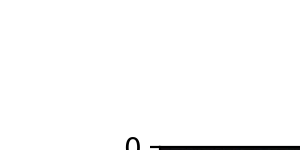

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_name = df_mobile.loc[df_mobile['objectId'] == 'm51', 'destination'].iloc[0]
image = Image.open(image_name)

# Create a plot to display the image
fig, ax = plt.subplots()
ax.imshow(image)

# Function to handle click events
def onclick(event):
    # Get the x and y coordinates of the click
    x, y = int(event.xdata), int(event.ydata)
    print(f'Pixel coordinates: (x: {x}, y: {y})')

# Connect the click event to the handler function
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


In [6]:
df_web[0:200]

,source,objectClass,objectId,duplicate,displayName,type,thumbnail,cropnail_dim
0,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC2362/NGC2362-St.png,DSO,ngc2362,False,Tau CMa,cluster,False,0
1,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC869/NGC_869-St.png,DSO,ngc869,False,NGC 869,cluster,False,0
2,/Users/jwatts/Documents/astrophotography/Final/DSO/M8/M8-St.png,DSO,m8,False,Lagoon Nebula,nebula,False,0
3,/Users/jwatts/Documents/astrophotography/Final/DSO/M1/M1-1/M1-St.png,DSO,m1,False,Crab Nebula,nebula,True,0
4,/Users/jwatts/Documents/astrophotography/Final/DSO/M31/M31-90sec-St.png,DSO,m31,False,Andromeda Galaxy,galaxy,False,0
5,/Users/jwatts/Documents/astrophotography/Final/DSO/M97/M97-St.png,DSO,m97,False,Owl Nebula,nebula,False,0
6,/Users/jwatts/Documents/astrophotography/Final/DSO/M101/M101-St.png,DSO,m101,False,M101,galaxy,False,0
7,/Users/jwatts/Documents/astrophotography/Final/DSO/M63/M63-St.png,DSO,m63,False,Sunflower Galaxy,galaxy,False,0
8,/Users/jwatts/Documents/astrophotography/Final/DSO/M82/M82-cbg-St.png,DSO,m82,False,Cigar Galaxy,galaxy,False,0
9,/Users/jwatts/Documents/astrophotography/Final/DSO/M78/M78-St.png,DSO,m78,False,M78,nebula,False,0


In [7]:
df_images[0:200]

,source,objectClass,objectId,duplicate,displayName,type
0,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC2362/NGC2362-St.png,DSO,ngc2362,False,Tau CMa,cluster
1,/Users/jwatts/Documents/astrophotography/Final/DSO/NGC869/NGC_869-St.png,DSO,ngc869,False,NGC 869,cluster
2,/Users/jwatts/Documents/astrophotography/Final/DSO/M8/M8-St.png,DSO,m8,False,Lagoon Nebula,nebula
3,/Users/jwatts/Documents/astrophotography/Final/DSO/M1/M1-1/M1-St.png,DSO,m1,False,Crab Nebula,nebula
4,/Users/jwatts/Documents/astrophotography/Final/DSO/M31/M31-90sec-St.png,DSO,m31,False,Andromeda Galaxy,galaxy
5,/Users/jwatts/Documents/astrophotography/Final/DSO/M97/M97-St.png,DSO,m97,False,Owl Nebula,nebula
6,/Users/jwatts/Documents/astrophotography/Final/DSO/M101/M101-St.png,DSO,m101,False,M101,galaxy
7,/Users/jwatts/Documents/astrophotography/Final/DSO/M63/M63-St.png,DSO,m63,False,Sunflower Galaxy,galaxy
8,/Users/jwatts/Documents/astrophotography/Final/DSO/M82/M82-cbg-St.png,DSO,m82,False,Cigar Galaxy,galaxy
9,/Users/jwatts/Documents/astrophotography/Final/DSO/M78/M78-St.png,DSO,m78,False,M78,nebula


In [8]:
df_dso[0:200]

,displayName,objectId,ra,dec,constellation,type,subType,magnitude,ngcId,recommended,field,UHC,OIII,id
0,NGC 869,ngc869,2.316056,57.133889,Perseus,cluster,OpenCluster,NaN,NGC 869,True,f/6.3,False,False,0
1,Veil Nebula,ngc6960,20.760556,30.708333,Cygnus,nebula,ISM,NaN,NGC 6960,True,f/6.3,True,True,0
2,Rosette Nebula,ldn1625,6.540767,4.793639,Monoceros,nebula,HIIReg,NaN,None,True,f/6.3,True,False,0
3,Helix Nebula,ngc7293,22.494040,-20.837152,Aquarius,nebula,PlanetaryNeb,13.524000,NGC 7293,True,f/10,True,True,0
4,Tau CMa,ngc2362,7.311389,-24.953889,Canis Major,cluster,OpenCluster,NaN,NGC 2362,True,f/10,False,False,0
5,Horsehead Nebula,ic434,5.683056,-2.458333,Orion,nebula,DarkNeb,NaN,None,True,f/10,True,False,0
6,Wizard Nebula,ngc7380,22.792222,58.048333,Cepheus,nebula,HIIReg,NaN,None,True,f/6.3,True,False,0
7,North America Nebula,ngc7000,20.979722,44.330000,Cygnus,cluster,Cluster*,NaN,NGC 7000,True,f/6.3,True,False,0
8,Crescent Nebula,ngc6888,20.201944,38.355000,Cygnus,nebula,ISM,NaN,NGC 6888,True,f/6.3,True,True,0
9,Stephan's Quintet,ngc7331,22.599306,33.960000,Pegasus,galaxy,Compact_Gr_G,NaN,None,True,f/10,False,False,0
